# ML7 Практика

Наша практика будет основана на соревновании Kaggle: Predicting a Biological Response (Прогнозирование биологического ответа).

Необходимо предсказать биологический ответ молекул (столбец '`Activity`') по их химическому составу (столбцы `D1-D1776`).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец `Activity` содержит экспериментальные данные, описывающие фактический биологический ответ `[0, 1]`; 
Остальные столбцы `D1-D1776` представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать `F1-score`.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (`GridSeachCV`, `RandomizedSearchCV`, `Hyperopt`, `Optuna`) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [347]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics

import hyperopt
from hyperopt import hp, tpe, space_eval, fmin
import optuna

import seaborn as sns

import time

In [348]:
# выносим глобальные переменные
random_state = 42
iter_number = 30

Загружаем данные

In [349]:
data = pd.read_csv('data/_train_sem09__1_.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Проверяем наличие пропусков

In [350]:
data.isna().sum().sum()

0

Смотрим на сбалансированность классов

<Axes: xlabel='Activity', ylabel='count'>

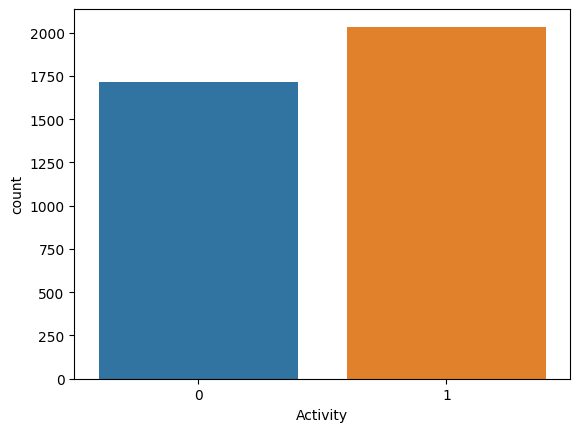

In [351]:
sns.countplot(data=data, x='Activity')

**Вывод**: классы довольно сбалансированны.

Создаём матрицу наблюдений и вектор ответов

In [352]:
X = data.drop(columns='Activity')
y = data['Activity']

Разделяем выборку на тренировочную и тестовую. Хоть выборка и более менее сбалансирована, всё равно проведём стратифицированное разбиение для чистоты эксперименты.

In [353]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('TRAIN shapes: ', X_train.shape, y_train.shape)
print('TEST shapes: ', X_test.shape, y_test.shape)

TRAIN shapes:  (3000, 1776) (3000,)
TEST shapes:  (751, 1776) (751,)


Создаём DataFrame для хранения метрик всех методов и моделей.

In [354]:
result = pd.DataFrame(columns=['method', 'model', 'F1-train', 'F1-test', 'time', 'params'])

## <center> **GridSearchCV**

### LogisticRegression

In [355]:
param_grid_lr = [
    {'penalty': ['l2', 'None'],
     'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
    
    {'penalty': ['l1', 'l2'],
     'solver': ['liblinear'],
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
    
    {'penalty': ['elasticnet', 'l1', 'l2', 'None'],
     'solver': ['saga'],
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search_lr = model_selection.GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=random_state,
        max_iter=1000
    ),
    param_grid=param_grid_lr,
    cv=5,
    n_jobs=-1
)

start_time = time.time()
grid_search_lr.fit(X_train, y_train)
end_time = time.time()

f1_lr_train = metrics.f1_score(y_train, grid_search_lr.predict(X_train))
f1_lr_test = metrics.f1_score(y_test, grid_search_lr.predict(X_test))
print(f'F1 на тренировочном наборе: {f1_lr_train:.2f}')
print(f'F1 на тестовом наборе: {f1_lr_test:.2f}')
print(f'лучшие значения гиперпараметров: {grid_search_lr.best_params_}')
print(f'лучшая модель:\n{grid_search_lr.best_estimator_}')

result = result.append({
    'method':'GridSearchCV',
    'model': 'LogisticRegression',
    'F1-train': round(f1_lr_train,2),
    'F1-test': round(f1_lr_test,2),
    'time': end_time - start_time,
    'params': grid_search_lr.best_params_
}, ignore_index=True)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

F1 на тренировочном наборе: 0.84
F1 на тестовом наборе: 0.78
лучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}
лучшая модель:
LogisticRegression(C=0.3, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')


### RandomForest

In [356]:
param_grid_rf = {
    'n_estimators': [5, 10, 30, 50, 70, 100, 120, 140, 160, 180, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 3, 5, 8, 13, 21],
    'min_samples_leaf': [2, 3, 5, 8, 13, 21, 34]
}

grid_search_rf = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1
)

start_time = time.time()
grid_search_rf.fit(X_train, y_train)
end_time = time.time()

f1_rf_train = metrics.f1_score(y_train, grid_search_rf.predict(X_train))
f1_rf_test = metrics.f1_score(y_test, grid_search_rf.predict(X_test))
print(f'F1 на тренировочном наборе: {f1_rf_train:.2f}')
print(f'F1 на тестовом наборе: {f1_rf_test:.2f}')
print(f'лучшие значения гиперпараметров: {grid_search_rf.best_params_}')
print(f'лучшая модель:\n{grid_search_rf.best_estimator_}')

result = result.append({
    'method':'GridSearchCV',
    'model': 'RandomForestClassifier',
    'F1-train': round(f1_rf_train,2),
    'F1-test': round(f1_rf_test,2),
    'time': end_time - start_time,
    'params': grid_search_rf.best_params_
}, ignore_index=True)

F1 на тренировочном наборе: 0.99
F1 на тестовом наборе: 0.80
лучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 21, 'min_samples_leaf': 2, 'n_estimators': 200}
лучшая модель:
RandomForestClassifier(max_depth=21, min_samples_leaf=2, n_estimators=200,
                       random_state=42)


## <center> **RandomizedSearchCV**

### LogisticRegression

In [357]:
param_distr_lr = [
    {'penalty': ['l2', 'None'],
     'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'C': list(np.linspace(0.01, 1, 10, dtype=float))},
    
    {'penalty': ['l1', 'l2'],
     'solver': ['liblinear'],
     'C': list(np.linspace(0.01, 1, 10, dtype=float))},
    
    {'penalty': ['elasticnet', 'l1', 'l2', 'None'],
     'solver': ['saga'],
     'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]

random_search_lr = model_selection.RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000),
    param_distributions=param_distr_lr,
    cv=5,
    n_iter=50,
    n_jobs=-1
)

start_time = time.time()
random_search_lr.fit(X_train, y_train)
end_time = time.time()

f1_rs_lr_train = metrics.f1_score(y_train, random_search_lr.predict(X_train))
f1_rs_lr_test = metrics.f1_score(y_test, random_search_lr.predict(X_test))
print(f'F1 на тренировочном наборе: {f1_rs_lr_train:.2f}')
print(f'F1 на тестовом наборе: {f1_rs_lr_test:.2f}')
print(f'лучшие значения гиперпараметров: {random_search_lr.best_params_}')
print(f'лучшая модель:\n{random_search_lr.best_estimator_}')

result = result.append({
    'method':'RandomizedSearchCV',
    'model': 'LogisticRegression',
    'F1-train': round(f1_rs_lr_train,2),
    'F1-test': round(f1_rs_lr_test,2),
    'time': end_time - start_time,
    'params': random_search_lr.best_params_
}, ignore_index=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

F1 на тренировочном наборе: 0.83
F1 на тестовом наборе: 0.78
лучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.23}
лучшая модель:
LogisticRegression(C=0.23, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')


### RandomForest

In [358]:
param_distr_rf = {
    'n_estimators': list(np.linspace(2, 300, 20, dtype=int)),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(np.linspace(2, 40, 10, dtype=int)),
    'min_samples_leaf': list(np.linspace(2, 40, 10, dtype=int))
}

random_search_rf = model_selection.RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_distributions=param_distr_rf,
    cv=5,
    n_iter=50,
    n_jobs=-1
)

start_time = time.time()
random_search_rf.fit(X_train, y_train)
end_time = time.time()

f1_rs_rf_train = metrics.f1_score(y_train, random_search_rf.predict(X_train))
f1_rs_rf_test = metrics.f1_score(y_test, random_search_rf.predict(X_test))
print(f'F1 на тренировочном наборе: {f1_rs_rf_train:.2f}')
print(f'F1 на тестовом наборе: {f1_rs_rf_test:.2f}')
print(f'лучшие значения гиперпараметров: {random_search_rf.best_params_}')
print(f'лучшая модель:\n{random_search_rf.best_estimator_}')

result = result.append({
    'method':'RandomizedSearchCV',
    'model': 'RandomForestClassifier',
    'F1-train': round(f1_rs_rf_train,2),
    'F1-test': round(f1_rs_rf_test,2),
    'time': end_time - start_time,
    'params': random_search_rf.best_params_
}, ignore_index=True)

F1 на тренировочном наборе: 0.99
F1 на тестовом наборе: 0.81
лучшие значения гиперпараметров: {'n_estimators': 237, 'min_samples_leaf': 2, 'max_depth': 18, 'criterion': 'log_loss'}
лучшая модель:
RandomForestClassifier(criterion='log_loss', max_depth=18, min_samples_leaf=2,
                       n_estimators=237, random_state=42)


## <center> Hyperopt

### LogisticRegression

In [359]:
# пространство поиска гиперпараметров
# т.к. выбор алгоритма зависит от выбора пенальти, то собираем массив из нескольких пространств
space_lr = hp.choice('space', [
    {'penalty': hp.choice('penalty1', ['l2', None]),
     'solver': hp.choice('solver', ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']),
     'C': hp.uniform('C1', 0.01, 1)
    },
    
    {'penalty': hp.choice('penalty2',['l1', 'l2']),
     'solver': 'liblinear',
     'C': hp.uniform('C2', 0.01, 1)
     },
    
    {'penalty': hp.choice('penalty3',['l1', 'l2', None]), ### 'elasticnet', 
     'solver': 'saga',
     'C': hp.uniform('C3', 0.01, 1)
     }
])

In [360]:
sace_test = {'penalty': hp.choice('penalty1', ['l2', None]),
     'solver': hp.choice('solver', ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']),
     'C': hp.uniform('C1', 0.01, 1, 0.1)
    }

In [361]:
# функция минимизации 
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    model_params = {'penalty': params['penalty'],
              'solver': params['solver'],
              'C': params['C']
              }
    model = linear_model.LogisticRegression(**model_params, random_state=random_state, max_iter=1000)
    score = model_selection.cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()
    
    return -score

In [362]:
# подбор гиперпараметров
trials_lr = hyperopt.Trials()

start_time = time.time()
best_lr = fmin(
    hyperopt_lr,
    space=space_lr,
    algo=tpe.suggest,
    max_evals=iter_number,
    trials=trials_lr,
    rstate=np.random.default_rng(random_state)
)
end_time = time.time()

print(f'Наилучшие значения гиперпараметров {space_eval(space_lr, best_lr)}')

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

  3%|▎         | 1/30 [00:22<10:49, 22.39s/trial, best loss: -0.7597800660015992]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  7%|▋         | 2/30 [00:56<13:46, 29.54s/trial, best loss: -0.7853881548973571]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 13%|█▎        | 4/30 [01:00<04:37, 10.67s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

 17%|█▋        | 5/30 [01:06<03:49,  9.18s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

 20%|██        | 6/30 [01:31<05:49, 14.58s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penal

 23%|██▎       | 7/30 [01:58<07:03, 18.40s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 30%|███       | 9/30 [02:01<03:20,  9.57s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 33%|███▎      | 10/30 [02:32<05:23, 16.20s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting pen

 37%|███▋      | 11/30 [02:38<04:12, 13.27s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

 40%|████      | 12/30 [03:01<04:50, 16.16s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 43%|████▎     | 13/30 [03:02<03:15, 11.48s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 47%|████▋     | 14/30 [03:32<04:33, 17.08s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 53%|█████▎    | 16/30 [03:42<02:37, 11.26s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

 60%|██████    | 18/30 [04:05<02:04, 10.37s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 63%|██████▎   | 19/30 [04:37<03:06, 16.95s/trial, best loss: -0.7892107732113662]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 30/30 [04:47<00:00,  9.59s/trial, best loss: -0.7911749231867716]
Наилучшие значения гиперпараметров {'C': 0.020965524378912193, 'penalty': 'l2', 'solver': 'liblinear'}


In [363]:
# расчитываем метрику F1 на подобранных гиперпараметрах
model_lr = linear_model.LogisticRegression(**space_eval(space_lr, best_lr), 
                                           random_state=random_state,
                                           max_iter=1000
                                           ).fit(X_train, y_train)

f1_ho_lr_train = metrics.f1_score(y_train, model_lr.predict(X_train))
f1_ho_lr_test = metrics.f1_score(y_test, model_lr.predict(X_test))

print(f'F1 на обучающем наборе: {f1_ho_lr_train:.2f}')
print(f'F1 на тестовом наборе: {f1_ho_lr_test:.2f}')

result = result.append({
    'method':'Hyperopt',
    'model': 'LogisticRegression',
    'F1-train': round(f1_ho_lr_train,2),
    'F1-test': round(f1_ho_lr_test,2),
    'time': end_time - start_time,
    'params': space_eval(space_lr, best_lr)
}, ignore_index=True)

F1 на обучающем наборе: 0.83
F1 на тестовом наборе: 0.78


### RandomForest

In [364]:
# пространство поиска гиперпараметров
space_rf = {
    'n_estimators': hp.quniform('n_estimators', 2, 300, 5),
    'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
    'max_depth': hp.quniform('max_depth', 2, 40, 2),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 40, 2)
}

In [365]:
random_state = 42
# функция минимизации 
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    model_params = {'n_estimators': int(params['n_estimators']),
              'criterion': params['criterion'],
              'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf'])
              }
    model = ensemble.RandomForestClassifier(**model_params, random_state=random_state)
    score = model_selection.cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()
    
    return -score

In [366]:
# подбор гиперпараметров
trials_rf = hyperopt.Trials()

start_time = time.time()
best_rf = fmin(
    hyperopt_rf,
    space=space_rf,
    algo=tpe.suggest,
    max_evals=iter_number,
    trials=trials_rf,
    rstate=np.random.default_rng(random_state)
)
end_time = time.time()

print(f'Наилучшие значения гиперпараметров {space_eval(space_rf, best_rf)}')

100%|██████████| 30/30 [00:27<00:00,  1.09trial/s, best loss: -0.8167721073950098]
Наилучшие значения гиперпараметров {'criterion': 'gini', 'max_depth': 30.0, 'min_samples_leaf': 2.0, 'n_estimators': 60.0}


In [367]:
# расчитываем метрику F1 на подобранных гиперпараметрах
model_rf = ensemble.RandomForestClassifier(criterion=space_eval(space_rf, best_rf)['criterion'],
                                           max_depth=int(space_eval(space_rf, best_rf)['max_depth']),
                                           min_samples_leaf=int(space_eval(space_rf, best_rf)['min_samples_leaf']),
                                           n_estimators=int(space_eval(space_rf, best_rf)['min_samples_leaf']),
                                           random_state=random_state
                                           ).fit(X_train, y_train)

f1_ho_rf_train = metrics.f1_score(y_train, model_rf.predict(X_train))
f1_ho_rf_test = metrics.f1_score(y_test, model_rf.predict(X_test))

print(f'F1 на обучающем наборе: {f1_ho_rf_train:.2f}')
print(f'F1 на тестовом наборе: {f1_ho_rf_test:.2f}')

result = result.append({
    'method':'Hyperopt',
    'model': 'RandomForestClassifier',
    'F1-train': round(f1_ho_rf_train,2),
    'F1-test': round(f1_ho_rf_test,2),
    'time': end_time - start_time,
    'params': space_eval(space_rf, best_rf)
}, ignore_index=True)

F1 на обучающем наборе: 0.88
F1 на тестовом наборе: 0.69


## <center> Optuna

### LogisticRegression

In [368]:
random_state = 42

# настраиваем оптимизацию гиперпараметров
def optuna_lr(trial):
    # пространство поиска гиперпараметров

    # optuna пока не позволяет задавать несколько suggest_categorical для одного параметра, выдаёт ошибку:
    # CategoricalDistribution does not support dynamic value space
    # поэтому приходится изощряться с одним выбором.
    # иначе код ниже работал бы:
    
    # solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
    # penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None])
    # if solver in ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']:
    #     penalty = trial.suggest_categorical('penalty', ['l2', None])
    # elif solver == 'liblinear':
    #     penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    # else:
    #     penalty = trial.suggest_categorical('penalty', ['elasticnet', 'l1', 'l2', None])
    
    solver_and_penalty = trial.suggest_categorical('mark', [
        ['lbfgs', 'l2'],
        ['lbfgs', None],
        ['liblinear', 'l1'],
        ['liblinear', 'l2'],
        ['newton-cg', 'l2'],
        ['newton-cg', None],
        ['newton-cholesky', 'l2'],
        ['newton-cholesky', None],
        ['sag', 'l2'],
        ['sag', None],
        # ['saga', 'elasticnet'], # по каким-то причинам эта комбинация выдаёт ошибку вызова '-' у int. Разберусь позже.
        ['saga', 'l1'],
        ['saga', 'l2'],
        ['saga', None],
    ])
    c = trial.suggest_float("C", 0.01, 1.0, step=0.1)
    
    # создаём и обучаем модель
    model_lr = linear_model.LogisticRegression(
        solver=solver_and_penalty[0],
        penalty=solver_and_penalty[1],
        C=c,
        random_state=random_state,
        max_iter=1000
    ).fit(X_train, y_train)
    
    return metrics.f1_score(y_train, model_lr.predict(X_train))

In [369]:
%%time
# создаём объект исследования
study_lr = optuna.create_study(study_name='LogisticRegression', direction='maximize')
start_time = time.time()
study_lr.optimize(optuna_lr, n_trials=iter_number)
end_time = time.time()

[I 2023-05-02 23:57:34,540] A new study created in memory with name: LogisticRegression
[I 2023-05-02 23:57:38,070] Trial 0 finished with value: 0.8234239617567971 and parameters: {'mark': ['newton-cholesky', 'l2'], 'C': 0.01}. Best is trial 0 with value: 0.8234239617567971.
[I 2023-05-02 23:57:44,963] Trial 1 finished with value: 0.9880478087649402 and parameters: {'mark': ['newton-cholesky', None], 'C': 0.41000000000000003}. Best is trial 1 with value: 0.9880478087649402.
[I 2023-05-02 23:58:14,616] Trial 2 finished with value: 0.8275245755138516 and parameters: {'mark': ['saga', 'l1'], 'C': 0.21000000000000002}. Best is trial 1 with value: 0.9880478087649402.
[I 2023-05-02 23:58:27,407] Trial 3 finished with value: 0.8871359223300971 and parameters: {'mark': ['saga', 'l2'], 'C': 0.7100000000000001}. Best is trial 1 with value: 0.9880478087649402.
[I 2023-05-02 23:58:42,715] Trial 4 finished with value: 0.9972367209088118 and parameters: {'mark': ['newton-cg', None], 'C': 0.410000000

CPU times: user 27min 54s, sys: 40 s, total: 28min 34s
Wall time: 7min 12s


In [370]:
# расчитаем метрики на обучающей и тестовой выборке
f1_op_lr_train = study_lr.best_value
print(f'f1_score на обучающем наборе: {f1_op_lr_train:.2f}')

model_lr_optuna = linear_model.LogisticRegression(
        solver=study_lr.best_params['mark'][0],
        penalty=study_lr.best_params['mark'][1],
        C=study_lr.best_params['C'],
        random_state=random_state,
        max_iter=1000
    ).fit(X_train, y_train)

f1_op_lr_test = metrics.f1_score(y_test, model_lr_optuna.predict(X_test))
print(f'f1_score на тестовом наборе: {f1_op_lr_test:.2f}')

result = result.append({
    'method':'Optuna',
    'model': 'LogisticRegression',
    'F1-train': round(f1_op_lr_train,2),
    'F1-test': round(f1_op_lr_test,2),
    'time': end_time - start_time,
    'params': study_lr.best_params
}, ignore_index=True)


f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.71


### RandomForest

In [371]:
# настраиваем оптимизацию гиперпараметров
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 300, step=5)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 2, 40, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 40, step=2)
    
    model_rf = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                               criterion=criterion,
                                               max_depth=max_depth,
                                               min_samples_leaf=min_samples_leaf,
                                               random_state=random_state
                                               ).fit(X_train, y_train)
    return metrics.f1_score(y_train, model_rf.predict(X_train))

In [372]:
%%time
# создаём объект исследования
study_rf = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
start_time = time.time()
study_rf.optimize(optuna_rf, n_trials=iter_number)
end_time = time.time()

[I 2023-05-03 00:05:07,160] A new study created in memory with name: RandomForestClassifier
[I 2023-05-03 00:05:07,987] Trial 0 finished with value: 0.8823529411764707 and parameters: {'n_estimators': 117, 'criterion': 'gini', 'max_depth': 34, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.8823529411764707.
[I 2023-05-03 00:05:09,574] Trial 1 finished with value: 0.8417569193742478 and parameters: {'n_estimators': 297, 'criterion': 'log_loss', 'max_depth': 24, 'min_samples_leaf': 28}. Best is trial 0 with value: 0.8823529411764707.
[I 2023-05-03 00:05:10,886] Trial 2 finished with value: 0.8682779456193355 and parameters: {'n_estimators': 227, 'criterion': 'gini', 'max_depth': 22, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.8823529411764707.
[I 2023-05-03 00:05:12,309] Trial 3 finished with value: 0.8420735382760698 and parameters: {'n_estimators': 277, 'criterion': 'entropy', 'max_depth': 32, 'min_samples_leaf': 28}. Best is trial 0 with value: 0.8823529411764707.
[

CPU times: user 28.2 s, sys: 547 ms, total: 28.8 s
Wall time: 28.3 s


In [373]:
# расчитаем метрики на обучающей и тестовой выборке
f1_op_rf_train = study_rf.best_value
print(f'f1_score на обучающем наборе: {f1_op_rf_train:.2f}')

model_rf_optuna = ensemble.RandomForestClassifier(**study_rf.best_params, random_state=random_state).fit(X_train, y_train)

f1_op_rf_test = metrics.f1_score(y_test, model_rf_optuna.predict(X_test))
print(f'f1_score на тестовом наборе: {f1_op_rf_test:.2f}')

result = result.append({
    'method':'Optuna',
    'model': 'RandomForestClassifier',
    'F1-train': round(f1_op_rf_train,2),
    'F1-test': round(f1_op_rf_test,2),
    'time': end_time - start_time,
    'params': study_rf.best_params
}, ignore_index=True)

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.80


### Выводы

In [375]:
result

,method,model,F1-train,F1-test,time,params
0,GridSearchCV,LogisticRegression,0.84,0.78,280.027377,"{'C': 0.3, 'penalty': 'l1', 'solver': 'libline..."
1,GridSearchCV,RandomForestClassifier,0.99,0.80,621.703355,"{'criterion': 'gini', 'max_depth': 21, 'min_sa..."
2,RandomizedSearchCV,LogisticRegression,0.83,0.78,233.610708,"{'solver': 'saga', 'penalty': 'l1', 'C': 0.23}"
3,RandomizedSearchCV,RandomForestClassifier,0.99,0.81,38.272711,"{'n_estimators': 237, 'min_samples_leaf': 2, '..."
4,Hyperopt,LogisticRegression,0.83,0.78,287.629344,"{'C': 0.020965524378912193, 'penalty': 'l2', '..."
5,Hyperopt,RandomForestClassifier,0.88,0.69,27.602776,"{'criterion': 'gini', 'max_depth': 30.0, 'min_..."
6,Optuna,LogisticRegression,1.00,0.71,432.764639,"{'mark': ['newton-cg', None], 'C': 0.410000000..."
7,Optuna,RandomForestClassifier,0.99,0.80,28.285386,"{'n_estimators': 147, 'criterion': 'gini', 'ma..."


Мы обучили 2 модели и воспользовались четырьмя разными методами по подбору гиперпараметров.
На тестовых наборах данных эти методы дали примерно одинаковые результаты, если измерять метрикой `F1`, в районе 0.8. Только 2 показателя оказались существенно меньше:
* `Hyperopt	RandomForestClassifier`
* `Optuna	LogisticRegression`

Но при этом важно обратить внимание на разное количество времени, потраченное на обучение моделей и подбор параметров.
* Наибольшее количество времени понадобилось методу `GridSearchCV`, т.к. в нём осуществляется полный перебор заданных параметров.
* Наименьшее количество времени понадобилось методу `RandomizedSearchCV`, т.к. он выбирает рандомные показатели. При этом метрика схожа с `GridSearchCV`, но времени затрачено на порядок меньше
* Методы `Hyperopt` и `Optuna` показали примерно одинаковое количество времени. `Optuna` для `LogisticRegression` показала большое количество времени, но тут надо проверять настройки метода, возможно дело в этом. При этом эти методы должны учитывать предыдущие состояния, что в теории должно привести к лучшим результатам.

Основной вывод: нельзя сказать, что какой-то метод однозначно лучше другого. В идеале надо воспользоваться несколькими методами и выбрать лучший результат. Либо опираться на количество входных данных, ожидаемые затраты по времени и доступные мощности.